# Word2Vec

## Краткие выводы по проведенным экспериментам

### Лучшие настройки для кастомной реализации Word2Vec  (по наименьшему значению функции потерь):
SPACY_TOKENIZER (Lemmatizing, POS-tagging), VOCAB_SIZE = 2774 , NEGATIVE_SAMPLES_N = 25, BATCH_SIZE = 32, LEARNING_RATE = 0.01, RADIUS = 3, EMBEDDING_SIZE = 100, EPOCH_N = 10

### Оценка качества для лучшего пайплайна:
- среднее значение функции потерь на обучении 0.6641513660870333
- среднее значение функции потерь на валидации 0.6678653430058319

```
embeddings.most_similar('chicken_NOUN')
Out:
[('chicken_NOUN', 0.9999471),
 ('stock_NOUN', 0.5937826),
 ('turkey_NOUN', 0.56244886),
 ('duck_NOUN', 0.5497401),
 ('broth_NOUN', 0.53921604),
 ('pheasant_NOUN', 0.5330454),
 ('veal_NOUN', 0.5325875),
 ('beef_NOUN', 0.50705683),
 ('skate_NOUN', 0.5021599),
 ('breast_NOUN', 0.5007763)]

embeddings.analogy('cake_NOUN', 'cacao_NOUN', 'cheese_NOUN')
Out:
[('cacao_NOUN', 1.0826366),
 ('cheese_NOUN', 0.96782404),
 ('70_NUM', 0.73867005),
 ('queso_NOUN', 0.71897376),
 ('percent_NOUN', 0.70799565),
 ('solid_NOUN', 0.6984317),
 ('blanco_NOUN', 0.67209536),
 ('Muenster_PROPN', 0.67171854),
 ('Gruyère_PROPN', 0.6555697),
 ('chocolate_NOUN', 0.6345702)]
```

### Резюме:

1) Оптимальное количество эпох для обучения 30-40. \
2) Увеличение количества отрицательных примеров никак не повлияло на значение функции потерь. \
3) При уменьшении количества отрицательных примеров значение функции потерь немного увеличилось. \
4) При увеличении размера батча функция потерь немного уменьшается. \
5) При уменьшении или увеличении коэффициента скорости обучения значение функции потерь увеличивается. \
6) Чем меньше радиус окна, тем меньше итоговое значение функции потерь (был выбран радиус — 3). \
7) Изменение размера эмбеддинга практически никак не повлияло на значения функции потерь. \
8) После снятия ограничений на минимальную длину токенов для кастомного токенизатора (min_token_size=0) значение функции потерь довольно сильно уменьшилось. \
9) При использовании токенизатора из spacy значение функции потерь также получилось довольно низким. \
10) Лемматизация и POS-тэггинг особого прироста (существенного уменьшения значения функции потерь) качества не дают. \
11) Представления полученный из обученной модели FastText (реализация из gensim) являются довольно "содержательными".
12) При отображении полученных векторов на двумерную плоскость заметно, что эмбеддинги, полученые из реализаций gensim проецируются в более плотные облака по сравнению с облаками для кастомной реализации word2vec.

In [37]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [77]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import (
    tokenize_text_simple_regex,
    tokenize_corpus,
    build_vocabulary,
    texts_to_token_ids,
    PaddedSequenceDataset,
    Embeddings,
)
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Загрузка данных и подготовка корпуса

In [39]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [40]:
# # токенизируем
# train_tokenized = tokenize_corpus(
#     train_source,
#     tokenizer=tokenize_text_simple_regex,
#     min_token_size=0,
# )
# test_tokenized = tokenize_corpus(
#     test_source,
#     tokenizer=tokenize_text_simple_regex,
#     min_token_size=0,
# )

In [41]:
# !python3 -m spacy download en_core_web_lg

In [42]:
spacy_nlp = en_core_web_lg.load(disable=['parser', 'ner'])

In [43]:
def tokenize_corpus_with_spacy(
    texts, spacy_nlp, lemmatize=False, with_pos=False, delim="_"
):
    tokenized_corpus = list(spacy_nlp.pipe(texts))
    result = []

    for doc in tokenized_corpus:
        tokenized_text = []

        for token in doc:
            token_cont = token.text if not lemmatize else token.lemma_

            if with_pos:
                token_cont += delim + token.pos_

            tokenized_text.append(token_cont)

        result.append(tokenized_text)

    return result


LEMMATIZE_MODE_SPACY_TOKENIZER = True
POS_ADD_MODE_SPACY_TOKENIZER = False
DELIM = "_"

In [79]:
import spacy
import en_core_web_lg

In [44]:
# токенизируем с SpaCy
train_tokenized = tokenize_corpus_with_spacy(
    train_source,
    spacy_nlp,
    lemmatize=LEMMATIZE_MODE_SPACY_TOKENIZER,
    with_pos=POS_ADD_MODE_SPACY_TOKENIZER,
    delim=DELIM,
)
test_tokenized = tokenize_corpus_with_spacy(
    test_source,
    spacy_nlp,
    lemmatize=LEMMATIZE_MODE_SPACY_TOKENIZER,
    with_pos=POS_ADD_MODE_SPACY_TOKENIZER,
    delim=DELIM,
)

In [45]:
print("\n".join(" ".join(sent) for sent in train_tokenized[:10]))

1/4 cup sour cream
10 ounce swordfish , red snapper or other firm - flesh fish
1 tablespoon mince basil leave
handful fresh parsley , finely mince
4 ounce lard or butter , plus more for brush top
4 to 5 green cardamom pod
1 stick ( 1/4 pound ) unsalted butter , soften
1/4 teaspoon red pepper flake , preferably turkish or Aleppo ( see note ) , more to taste
1 tablespoon fresh lemon juice
1/4 cup scallion , thinly slice


In [46]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2421
[('<PAD>', 0), ('1', 1), (',', 2), ('cup', 3), ('2', 4), ('tablespoon', 5), ('1/2', 6), ('teaspoon', 7), ('and', 8), ('or', 9)]


In [47]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

17 3 270 77
115 26 933 2 47 618 9 156 292 10 610 219
1 5 32 118 53
464 23 65 2 30 32
22 26 616 9 35 2 67 71 41 652 364
22 12 79 75 387 476
1 165 14 17 18 15 74 35 2 308
17 7 47 16 168 2 102 1271 9 808 14 133 175 15 2 71 12 24
1 5 23 51 46
17 3 111 2 90 33


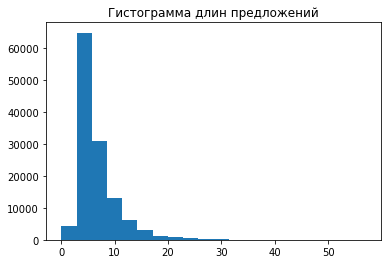

In [48]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [49]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([ 17,   3, 270,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [50]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [51]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [52]:
# VOCAB_SIZE = len(vocabulary)

# NEGATIVE_SAMPLES_N = 25
# BATCH_SIZE = 8
# LEARNING_RATE = 1e-2
# RADIUS = 5

# EMBEDDING_SIZE = 100
# EPOCH_N = 2

VOCAB_SIZE = len(vocabulary)

NEGATIVE_SAMPLES_N = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
RADIUS = 3

EMBEDDING_SIZE = 100
EPOCH_N = 10

In [53]:
print(f"Настройки: VOCAB_SIZE = {VOCAB_SIZE}, NEGATIVE_SAMPLES_N = {NEGATIVE_SAMPLES_N}, BATCH_SIZE = {BATCH_SIZE}, LEARNING_RATE = {LEARNING_RATE}, RADIUS = {RADIUS}, EMBEDDING_SIZE = {EMBEDDING_SIZE}, EPOCH_N = {EPOCH_N}")

Настройки: VOCAB_SIZE = 2421, NEGATIVE_SAMPLES_N = 25, BATCH_SIZE = 32, LEARNING_RATE = 0.01, RADIUS = 3, EMBEDDING_SIZE = 100, EPOCH_N = 10


In [54]:
trainer = SkipGramNegativeSamplingTrainer(VOCAB_SIZE, EMBEDDING_SIZE, MAX_SENTENCE_LEN,
                                          radius=RADIUS, negative_samples_n=NEGATIVE_SAMPLES_N)

In [55]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=LEARNING_RATE,
                                            epoch_n=EPOCH_N,
                                            batch_size=BATCH_SIZE,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 6.16 сек
Среднее значение функции потерь на обучении 0.6834770782717104
Среднее значение функции потерь на валидации 0.6745831731744577
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 5.84 сек
Среднее значение функции потерь на обучении 0.674114192622355
Среднее значение функции потерь на валидации 0.6730319191970734
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 7.77 сек
Среднее значение функции потерь на обучении 0.6724413355429848
Среднее значение функции потерь на валидации 0.6724502380722118
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 6.75 сек
Среднее значение функции потерь на обучении 0.6722195491321321
Среднее значение функции потерь на валидации 0.6724097673704115
Новая лучшая модель!

Эпоха 4
Эпоха: 2001 итераций, 6.39 сек
Среднее значение функции потерь на обучении 0.6713825655483949
Среднее значение функции потерь на валидации 0.672586668666592
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 и

In [56]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [57]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [58]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [60]:
embeddings.most_similar('chicken')

[('chicken', 0.99994814),
 ('turkey', 0.6257158),
 ('duck', 0.6200876),
 ('stock', 0.59152544),
 ('broth', 0.5777407),
 ('veal', 0.56211615),
 ('quail', 0.5464175),
 ('beef', 0.5453203),
 ('breast', 0.5371977),
 ('duckling', 0.5347004)]

In [61]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 1.1057864),
 ('cheese', 0.8348418),
 ('sheep', 0.7909725),
 ('percent', 0.6892953),
 ('calvado', 0.6671251),
 ('Gruyere', 0.6615943),
 ('Branca', 0.65715),
 ('Reserve', 0.63216716),
 ('cassis', 0.61844105),
 ('fromage', 0.6161181)]

In [62]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(17, 100)


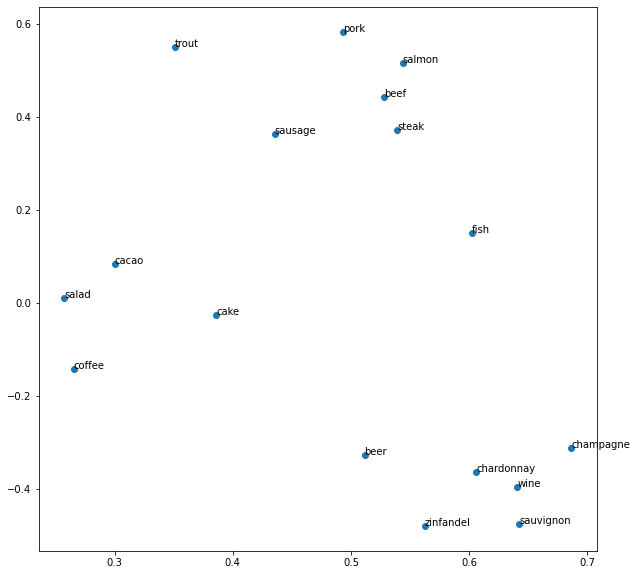

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [64]:
import gensim

In [65]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [66]:
word2vec.wv.most_similar('chicken')

[('pheasant', 0.7188981771469116),
 ('rabbit', 0.6905457973480225),
 ('duck', 0.6731789112091064),
 ('turkey', 0.6723127365112305),
 ('thigh', 0.6696413159370422),
 ('duckling', 0.6642704010009766),
 ('brisket', 0.657634973526001),
 ('stock', 0.6455907821655273),
 ('broth', 0.6358869075775146),
 ('skate', 0.6215320825576782)]

In [67]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

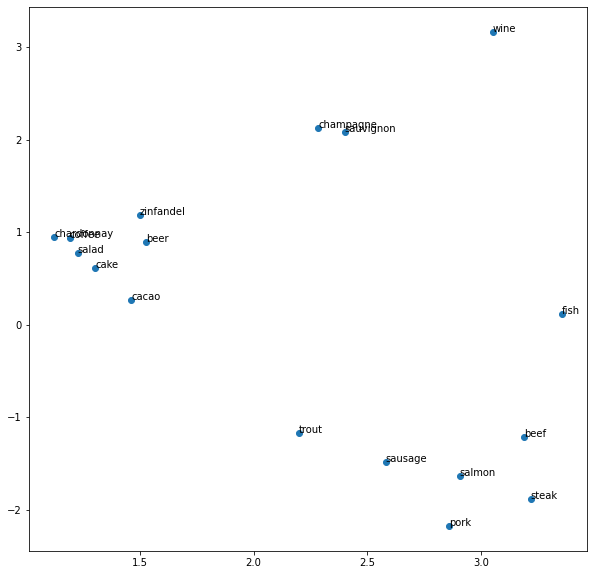

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Обучение FastText с помощью Gensim

In [69]:
import gensim

In [70]:
fasttext = gensim.models.FastText(
    sentences=train_tokenized, size=100, window=5, min_count=5, workers=4, sg=1, iter=10
)

In [71]:
fasttext.wv.most_similar('chicken_NOUNT')

[('chicken', 0.9287378787994385),
 ('chick', 0.7206724882125854),
 ('duck', 0.6634989976882935),
 ('thigh', 0.6427212357521057),
 ('turkey', 0.6352545022964478),
 ('rabbit', 0.6288781762123108),
 ('stock', 0.6000908017158508),
 ('pheasant', 0.5917993783950806),
 ('drumstick', 0.5890626907348633),
 ('broth', 0.5815339684486389)]

In [72]:
gensim_words = [w for w in test_words if w in fasttext.wv.vocab]
gensim_vectors = np.stack([fasttext.wv[w] for w in gensim_words])

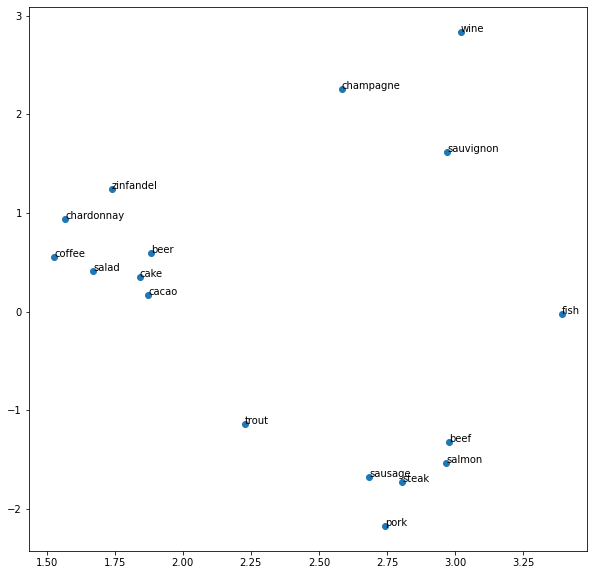

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [ ]:
import gensim.downloader as api

In [ ]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

In [ ]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [ ]:
pretrained.most_similar('cheese')

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают